## Installing Necessary Packages

In [1]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender &> /dev/null
!pip install imageio==2.4.1 &> /dev/null
!pip install --upgrade AutoROM &> /dev/null
!AutoROM --accept-license &> /dev/null
!pip install gym[atari,accept-rom-license] &> /dev/null

## Importing Necessary Packages

In [2]:
import gym
import os
import torch
import random
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as f
from collections import namedtuple, deque
%matplotlib inline
from IPython import display as ipythondisplay
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Hyperparameters

In [3]:
BATCH_SIZE = 128
BUFFER_SIZE = 1000000
GAMMA = 0.99
LR = 0.00025
FREQUENCY = 5
TAU = 0.005

## Replay Buffer (Store <state, action, reward, next_state, done>)

In [4]:
class ReplayBuffer:

  def __init__(self, action_size, buffer_size, batch_size, seed):
    self.action_size = action_size
    self.memory = deque(maxlen=buffer_size)
    self.batch_size = batch_size

    self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    self.seed = random.seed(seed)

  def add(self, state, action, reward, next_state, done):
    self.memory.append(self.experience(state, action, reward, next_state, done))

  def sample(self):
    experience = random.sample(self.memory, k=self.batch_size)

    states = torch.from_numpy(np.vstack([i.state for i in experience if i is not None])).float()
    actions = torch.from_numpy(np.vstack([i.action for i in experience if i is not None])).float()
    rewards = torch.from_numpy(np.vstack([i.reward for i in experience if i is not None])).float()
    next_states = torch.from_numpy(np.vstack([i.next_state for i in experience if i is not None])).float()
    dones = torch.from_numpy(np.vstack([i.done for i in experience if i is not None]).astype(np.uint8)).float()

    return (states, actions, rewards, next_states, dones)

  def __len__(self):
    return len(self.memory)


## Newtork Type 1 (Mean Advantage)

In [23]:
class QNetworkType1(nn.Module):

  def __init__(self, state_size, action_size, seed):
    super(QNetworkType1, self).__init__()
    self.seed = torch.manual_seed(seed)

    self.layer1 = nn.Linear(state_size, 512)
    # self.layer2 = nn.Linear(128, 128)

    self.value_function = nn.Linear(512, 1)

    self.advantage = nn.Linear(512, action_size)

  def forward(self, state):

    # x = f.relu(self.layer2(f.relu(self.layer1(state))))
    x = f.relu(self.layer1(state))
    value_function = self.value_function(x)
    advantage = self.advantage(x)

    return value_function + (advantage-advantage.mean(dim=1, keepdim=True))

## Network Type 2 (Max Advantage)

In [24]:
class QNetworkType2(nn.Module):

  def __init__(self, state_size, action_size, seed):
    super(QNetworkType2, self).__init__()
    self.seed = torch.manual_seed(seed)

    self.layer1 = nn.Linear(state_size, 512)
    # self.layer2 = nn.Linear(128, 128)

    self.value_function = nn.Linear(512, 1)

    self.advantage = nn.Linear(512, action_size)

  def forward(self, state):

    # x = f.relu(self.layer2(f.relu(self.layer1(state))))
    x = f.relu(self.layer1(state))
    value_function = self.value_function(x)
    advantage = self.advantage(x)

    return value_function + (advantage-advantage.max(dim=1, keepdim=True)[0])

## Agent

In [25]:
class Agent():
  def __init__(self, state_size, action_size, seed, qnetwork = QNetworkType1):
    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    self.qnetworkPrimary = qnetwork(state_size, action_size, seed)
    self.qnetworkTarget = qnetwork(state_size, action_size, seed)

    self.optimizer = optim.Adam(self.qnetworkPrimary.parameters(), lr=LR)

    self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
    self.timestep = 0

  def step(self, state, action, reward, next_state, done):
    self.memory.add(state, action, reward, next_state, done)

    self.timestep = (self.timestep + 1) % FREQUENCY
    if self.timestep == 0:
      if len(self.memory) > BATCH_SIZE:
        experiences = self.memory.sample()
        self.learn(experiences, GAMMA)

  def learn(self, experience, gamma):
    states, actions, rewards, next_states, dones = experience

    q_nextTarget = self.qnetworkTarget(next_states).detach().max(1)[0].unsqueeze(1)
    actions = actions.type(torch.int64)
    q_Target = rewards + (gamma*q_nextTarget*(1-dones))
    q_Expected = self.qnetworkPrimary(states).gather(1, actions)

    loss = f.mse_loss(q_Expected, q_Target)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.update(self.qnetworkPrimary, self.qnetworkTarget, TAU)

  def update(self, primaryNetwork, targetNetwork, tau):

    for target_param, local_param in zip(targetNetwork.parameters(), primaryNetwork.parameters()):
      target_param.data.copy_(tau*local_param.data + (1 - tau)*target_param.data)

  def move(self, state, eps=0):
    state = torch.from_numpy(state).float().unsqueeze(0)
    self.qnetworkPrimary.eval()
    with torch.no_grad():
      action_values = self.qnetworkPrimary(state)
    self.qnetworkPrimary.train()

    if random.random() > eps:
      return np.argmax(action_values.data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

## Dueling DQN 

In [26]:
def duelingDQN(agent, episodes = 2000, max_timestep = 1000, ep_start = 1.0, ep_end = 0.001, ep_decay = 0.9975, exp_no = 3):
  scores= []
  scores_window = deque(maxlen = 100)
  epsilon = ep_start

  for episode in range(1, episodes+1):
    state = env.reset()
    score = 0

    for t in range(max_timestep):
      action = agent.move(state, epsilon)
      next_state, reward, done, _ = env.step(action)
      agent.step(state, action, reward, next_state, done)
      score+=reward
      state = next_state
      if done:
        break

    scores_window.append(score)
    scores.append(score)
    epsilon = max(ep_end, ep_decay*epsilon)

    # print(f'Episode {episode}    Average Score: {np.mean(scores_window)}')
    if episode % 100 == 0:
      print(f'Episode {episode}    Average Score: {np.mean(scores_window)}')
    if np.mean(scores_window) >= env.spec.reward_threshold:
      print(f"Environment solved in {episode} episodes !!!!   Average Score: {np.mean(scores_window)}")
      file_name = 'cartpole_model_weights'+str(exp_no)+'.pth'
      torch.save(agent.qnetworkPrimary.state_dict(), file_name)
      break

  return scores

## Multiple Seed 

In [27]:
def multiple_experiments(agent, num_seeds=5, exp_no = 1):
    all_scores = []
    min_length = float('inf')

    for seed in range(num_seeds):
        print(f"\nTraining with seed {seed+1}\n")
        env.seed(seed)
        scores = duelingDQN(agent=agent, exp_no = exp_no)
        all_scores.append(scores)

        min_length = min(min_length, len(scores))
    # Calculate the average scores across all seeds for each episode

    all_scores_dim = [score[:min_length] for score in all_scores]
    return all_scores_dim

## Experiment 3: Cartpole - Type 1 

In [28]:
print("######## Experiment 3: Dueling DQN Type 1 ############\n")
print("######## Environment 2: Cartpole ############")
print(" ")
env = gym.make('CartPole-v1')
env.seed(0)

print(f"Observation Space: {env.observation_space}\n")
print(f"Observation Space Shape: {env.observation_space.shape}\n")
print(f"Action Space: {env.action_space}\n")
print(f"Number of Actions: {env.action_space.n}\n")
print(f"Reward Threshold: {env.spec.reward_threshold}")

cartpole_agent_type1 = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0, qnetwork=QNetworkType1)

######## Experiment 3: Dueling DQN Type 1 ############

######## Environment 2: Cartpole ############
 
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

Observation Space Shape: (4,)

Action Space: Discrete(2)

Number of Actions: 2

Reward Threshold: 475.0


## Training Over 5 Random Seeds

In [29]:
scores_experiment3 = multiple_experiments(agent=cartpole_agent_type1, exp_no=3)


Training with seed 1



Episode 100    Average Score: 18.67
Episode 200    Average Score: 16.58
Episode 300    Average Score: 39.42
Episode 400    Average Score: 155.71
Episode 500    Average Score: 245.58
Episode 600    Average Score: 271.18
Episode 700    Average Score: 285.92
Episode 800    Average Score: 278.24
Episode 900    Average Score: 268.32
Episode 1000    Average Score: 257.59
Episode 1100    Average Score: 260.63
Episode 1200    Average Score: 276.86
Episode 1300    Average Score: 268.87
Episode 1400    Average Score: 280.59
Episode 1500    Average Score: 275.7
Episode 1600    Average Score: 288.1
Episode 1700    Average Score: 292.57
Episode 1800    Average Score: 304.16
Episode 1900    Average Score: 314.2
Episode 2000    Average Score: 323.44

Training with seed 2

Episode 100    Average Score: 26.95
Episode 200    Average Score: 50.24
Episode 300    Average Score: 83.21
Episode 400    Average Score: 146.42
Episode 500    Average Score: 244.78
Episode 600    Average Score: 284.47
Episode 700  

## Training Once (Save Model)

In [30]:
scores = duelingDQN(agent=cartpole_agent_type1, exp_no = 3)

Episode 100    Average Score: 29.43
Episode 200    Average Score: 41.54
Episode 300    Average Score: 68.25
Episode 400    Average Score: 159.37
Episode 500    Average Score: 292.45
Episode 600    Average Score: 378.04
Episode 700    Average Score: 444.75
Environment solved in 796 episodes !!!!   Average Score: 476.35


## Test Model (Video)

In [ ]:
cartpole_agent_type1.qnetworkPrimary.load_state_dict(torch.load('cartpole_model_weights3.pth'))

frames = []
for _ in range(1):
    state = env.reset()
    for _ in range(500):
        action = cartpole_agent_type1.move(state)
        state, _, done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break

image_dir = './cartpole_images_experiment3'
os.makedirs(image_dir, exist_ok=True)
for i, frame in enumerate(frames):
    image_path = os.path.join(image_dir, f'frame_{i}.png')
    plt.imsave(image_path, frame)

import subprocess
video_path = './cartpole_video_experiment3.mp4'
subprocess.call(['ffmpeg', '-framerate', '25', '-i', os.path.join(image_dir, 'frame_%d.png'), '-c:v', 'libx264', '-pix_fmt', 'yuv420p', video_path])

## Experiment 4: Cartpole - Type 2

In [32]:
print("######## Experiment 4: Dueling DQN Type 2 ############\n")
print("######## Environment 2: Cartpole ############")
print(" ")
env = gym.make('CartPole-v1')
env.seed(0)

print(f"Observation Space: {env.observation_space}\n")
print(f"Observation Space Shape: {env.observation_space.shape}\n")
print(f"Action Space: {env.action_space}\n")
print(f"Number of Actions: {env.action_space.n}\n")
print(f"Reward Threshold: {env.spec.reward_threshold}")

cartpole_agent_type2 = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0, qnetwork=QNetworkType2)

######## Experiment 4: Dueling DQN Type 2 ############

######## Environment 2: Cartpole ############
 
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

Observation Space Shape: (4,)

Action Space: Discrete(2)

Number of Actions: 2

Reward Threshold: 475.0


## Training Over 5 Random Seeds

In [33]:
scores_experiment4 = multiple_experiments(agent=cartpole_agent_type2, exp_no=4)


Training with seed 1



Episode 100    Average Score: 22.71
Episode 200    Average Score: 25.22
Episode 300    Average Score: 76.5
Episode 400    Average Score: 187.36
Episode 500    Average Score: 255.1
Episode 600    Average Score: 283.04
Episode 700    Average Score: 281.75
Episode 800    Average Score: 305.94
Episode 900    Average Score: 304.22
Episode 1000    Average Score: 310.4
Episode 1100    Average Score: 321.53
Episode 1200    Average Score: 337.09
Episode 1300    Average Score: 348.45
Episode 1400    Average Score: 355.23
Episode 1500    Average Score: 357.16
Episode 1600    Average Score: 353.88
Episode 1700    Average Score: 359.49
Episode 1800    Average Score: 370.88
Episode 1900    Average Score: 373.73
Episode 2000    Average Score: 406.13

Training with seed 2

Episode 100    Average Score: 29.23
Episode 200    Average Score: 56.13
Episode 300    Average Score: 117.44
Episode 400    Average Score: 196.95
Episode 500    Average Score: 281.86
Episode 600    Average Score: 307.71
Episode 700 

## Training Once (Save Model)

In [34]:
scores = duelingDQN(agent=cartpole_agent_type2, exp_no = 4)

Episode 100    Average Score: 27.87
Episode 200    Average Score: 52.58
Episode 300    Average Score: 116.87
Episode 400    Average Score: 205.7
Episode 500    Average Score: 300.28
Episode 600    Average Score: 434.96
Episode 700    Average Score: 451.48
Episode 800    Average Score: 404.25
Episode 900    Average Score: 421.28
Episode 1000    Average Score: 401.54
Episode 1100    Average Score: 456.02
Episode 1200    Average Score: 470.95
Environment solved in 1227 episodes !!!!   Average Score: 475.49


## Testing Model (Video)

In [ ]:
cartpole_agent_type2.qnetworkPrimary.load_state_dict(torch.load('cartpole_model_weights4.pth'))

frames = []
for _ in range(1):
    state = env.reset()
    for _ in range(500):
        action = cartpole_agent_type2.move(state)
        state, _, done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break

image_dir = './cartpole_images_experiment4'
os.makedirs(image_dir, exist_ok=True)
for i, frame in enumerate(frames):
    image_path = os.path.join(image_dir, f'frame_{i}.png')
    plt.imsave(image_path, frame)

import subprocess
video_path = './cartpole_video_experiment4.mp4'
subprocess.call(['ffmpeg', '-framerate', '25', '-i', os.path.join(image_dir, 'frame_%d.png'), '-c:v', 'libx264', '-pix_fmt', 'yuv420p', video_path])

## Plot for Mean and Variance (Type 1 vs Type 2)

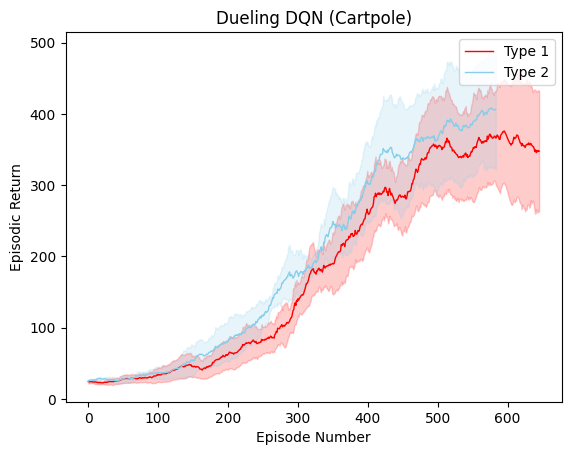

In [42]:
window_size = 30
scores1, scores2 = [], []

for i in range(5):
    scores1.append(np.convolve(scores_experiment3[i], np.ones(window_size)/window_size, mode="valid"))
    scores2.append(np.convolve(scores_experiment4[i], np.ones(window_size)/window_size, mode="valid"))

mean_scores_exp3, mean_scores_exp4 = np.mean(scores1, axis=0), np.mean(scores2, axis=0)
std_scores_exp3, std_scores_exp4 = np.std(scores1, axis=0), np.std(scores2, axis=0)

sns.lineplot(x=range(len(mean_scores_exp3)), y=mean_scores_exp3, linewidth=1, label='Type 1', color="red")
sns.lineplot(x=range(len(mean_scores_exp4)), y=mean_scores_exp4, linewidth=1, label='Type 2', color="skyblue")

plt.fill_between(
    x=range(len(mean_scores_exp3)),
    y1=mean_scores_exp3 - std_scores_exp3[0:len(mean_scores_exp3)],
    y2=mean_scores_exp3 + std_scores_exp3[0:len(mean_scores_exp3)],
    alpha=0.2, 
    color='red'
)
plt.fill_between(
    x=range(len(mean_scores_exp4)),
    y1=mean_scores_exp4 - std_scores_exp4[0:len(mean_scores_exp4)],
    y2=mean_scores_exp4 + std_scores_exp4[0:len(mean_scores_exp4)],
    alpha=0.2,
    color='skyblue'
)

plt.xlabel('Episode Number')
plt.ylabel('Episodic Return')
plt.title('Dueling DQN (Cartpole)')
plt.legend()
plt.show()
